<a href="https://colab.research.google.com/github/WilliamAshbee/splineexample/blob/main/DatasciencePresentation.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
epoch = 40

x0_y0_r_xrf_yrf torch.Size([100, 1]) torch.Size([100, 1]) torch.Size([100, 1000]) torch.Size([1, 1000]) torch.Size([1, 1000])


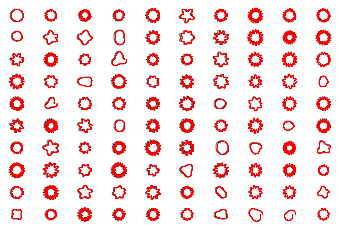

In [2]:
import torch
import numpy as np
import pylab as plt
from skimage import filters
import math

global numpoints
numpoints = 1000
side = 32

rows = torch.zeros(32,32)
columns = torch.zeros(32,32)


for i in range(32):
    columns[:,i] = i
    rows[i,:] = i


def donut_matrix(length = 10):
    radiusMax = side /3
    w = 1
    sigmas = [None, 1]
    
    canvas = torch.zeros((length,side, side))
    r0 = torch.tensor(np.random.uniform(side/4, side/3, length))

    radii = torch.zeros((length,numpoints))
    radii[:, :] = r0.unsqueeze(1)
    
    ind = [x for x in range(numpoints)]

    theta = torch.FloatTensor(ind)
    theta *= math.pi*2.0/(float)(numpoints)
    
    for i in range(1,length):
        a = np.random.uniform(1.0,3.0)*torch.sin(np.random.uniform(20.0)*theta+np.random.uniform(1000.0))
        radii[i,:] += a
    
    assert torch.min(radii)>0
    rmaxs = radii.max(axis = 1)[0]
    pmins = rmaxs+1.0
    pmaxs = side-rmaxs-1.0
    x0 = np.random.uniform(pmins,pmaxs)
    y0 = np.random.uniform(pmins,pmaxs)
    x0[:]=side/2
    y0[:]=side/2
    x0 = torch.tensor(x0)
    y0 = torch.tensor(y0)
    
    x0 = x0.unsqueeze(1)
    y0 = y0.unsqueeze(1)
    xrfactors = torch.cos(theta).unsqueeze(0)
    yrfactors = torch.sin(theta).unsqueeze(0)
    
    print('x0_y0_r_xrf_yrf',x0.shape,y0.shape,radii.shape,xrfactors.shape,yrfactors.shape)

    x = (x0+(xrfactors*radii))
    y = (y0+(yrfactors*radii))
    assert x.shape == (length,numpoints)
    assert y.shape == (length,numpoints)
    assert torch.sum(x[x>(side-1)])==0 
    assert torch.sum(x[x<0])==0 
    assert torch.sum(y[y>(side-1)])==0 
    assert torch.sum(y[y<0])==0 
    
    points = torch.zeros(length,numpoints,2)
    for l in range(length):
        canvas[l,y[l,:].type(torch.LongTensor),x[l,:].type(torch.LongTensor)]=1.0
        points[l,:,0] = x[l,:]#modified for lstm discriminator
        points[l,:,1] = y[l,:]#modified for lstm discriminator 
    
    
    return {
        'canvas': canvas, 
        'points':points.type(torch.FloatTensor)}


def plot_all( sample = None, model = None, labels = None):
    img = sample[:,:].squeeze().cpu().numpy()
    plt.imshow(img, cmap=plt.cm.gray_r)
    if model != None:
        with torch.no_grad():
            global numpoints

            #sample = torch.stack([sample for i in range(64)],dim = 0).cuda()
            pred = model(sample.cuda())#come back to this
            predres = numpoints
            X = pred[0,:,0]
            Y = pred[0,:,1]
            assert X.shape[0] == 1000
            assert Y.shape[0] == 1000
            s = [.001 for x in range(predres)]
            
            assert len(s) == predres
            c = ['red' for x in range(predres)]
            assert len(c) == predres
            Y = Y.cuda()
            X = X.cuda()
            plt.plot(X.cpu(),Y.cpu(),',-',c='red', ms=.1, lw=0.1) 

    else:
        X = labels[:,0]
        Y = labels[:,1]
        s = [.0001 for x in range(numpoints)]
        c = ['red' for x in range(numpoints)]
        plt.plot(X.cpu(),Y.cpu(),',-',c='red',  ms=.1, lw=0.1) 


class DonutDataset(torch.utils.data.Dataset):
    def __init__(self, length = 10):
        self.length = length
        self.values = donut_matrix(length)
        assert self.values['canvas'].shape[0] == self.length
        assert self.values['points'].shape[0] == self.length
        
        count = 0
        for i in range(self.length):
          a = self[i]
          c = a[0]
          for el in a[1]:
            y,x = (int)(el[1]),(int)(el[0])
            if x < side-2 and x > 2 and y < side-2 and y > 2: 
              if c[y,x] != 1 and \
                c[y+1,x] != 1 and c[y+1,-1+x] != 1 and c[y+1,1+x] != 1 and \
                c[y-1,x] != 1 and c[y,-1+x] != 1 and c[y,1+x] != 1:
                count+=1
        assert count ==0


    def __len__(self):
        return self.length


    def __getitem__(self, idx):
        canvas = self.values["canvas"]
        canvas = canvas[idx,:,:]
        assert canvas.shape == (side,side)
        points = self.values["points"]
        points = points[idx,:]
        #z = torch.zeros(numpoints,1)
        #points = torch.cat([points,z], dim = 1)
        
        return canvas, points
    
    @staticmethod
    def displayCanvas(title,dataset, model):
        for i in range(100):
            sample, labels = dataset[i]
            plt.subplot(10,10,i+1)
            plot_all(sample = sample,model=model, labels = labels)
            plt.axis('off')
        plt.savefig(title,dpi=1200)
        
test_dataset = DonutDataset(length = 100)

DonutDataset.displayCanvas('donut.png',test_dataset, model = None)


In [3]:
from torch.utils import data
from torch.utils.data import DataLoader, TensorDataset, RandomSampler

mini_batch = 64
#test_dataset = DonutDataset(length=100)
loader_test = data.DataLoader(
    test_dataset, 
    batch_size=mini_batch,
    sampler=RandomSampler(data_source=test_dataset),
    num_workers=4)


/usr/local/lib/python3.7/dist-packages/torch/utils/data/dataloader.py:477: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  cpuset_checked))


In [4]:
from torch.utils import data
from torch.utils.data import DataLoader, TensorDataset, RandomSampler

mini_batch = 64
dataset = DonutDataset(length=64*20)
loader_train = data.DataLoader(
    dataset, 
    batch_size=mini_batch,
    sampler=RandomSampler(data_source=dataset),
    num_workers=4)


x0_y0_r_xrf_yrf torch.Size([1280, 1]) torch.Size([1280, 1]) torch.Size([1280, 1000]) torch.Size([1, 1000]) torch.Size([1, 1000])


/usr/local/lib/python3.7/dist-packages/torch/utils/data/dataloader.py:477: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  cpuset_checked))


In [5]:
import torch
import torch.nn as nn
from torch.hub import load_state_dict_from_url

class MLP(nn.Module):
    def __init__(self):
        super(MLP, self).__init__()
        self.input_dim = 1*32*32
        self.output_dim = 2000
        self.net = nn.Sequential(
            nn.Linear(self.input_dim, self.input_dim),
            nn.ReLU(True),
            nn.Dropout(),
            nn.Linear(self.input_dim, self.input_dim),
            nn.ReLU(True),
            nn.Dropout(),
            nn.Linear(self.input_dim, self.output_dim),
            nn.Sigmoid()
        )
        
        

    def forward(self, x):
        #x = x.squeeze()
        if x.shape[0]!= mini_batch:
          assert x.shape[0] == 32 and x.shape[1] == 32
          x = x.unsqueeze(0)
        x = torch.flatten(x,start_dim=1)
        
        #assert x.shape == (mini_batch,self.hidden_dim)
        out = self.net(x)
        out = out.reshape(x.shape[0],1000,2)
        return 32.0*out


In [6]:
model = MLP().cuda()

In [7]:
optimizer = torch.optim.Adam(model.parameters(),lr = 0.0001, betas = (.9,.999))

In [8]:
loss = None
model = model.train()
for e in range(epoch):
  for xin,yin in loader_train:
    optimizer.zero_grad()

    if xin.shape[0] != mini_batch:
      print(xin.shape)
      continue
    xin = xin.cuda()
    yin = yin.cuda()
    out = model(xin)
    assert out.shape == yin.shape
    
    loss = torch.mean((out-yin)**2)
    loss.backward()
    optimizer.step()
    
  print('epoch',e,'\tTraining loss', loss.item())


/usr/local/lib/python3.7/dist-packages/torch/utils/data/dataloader.py:477: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  cpuset_checked))


epoch 0 	Training loss 17.494722366333008
epoch 1 	Training loss 6.001781940460205
epoch 2 	Training loss 4.4072585105896
epoch 3 	Training loss 3.6169304847717285
epoch 4 	Training loss 2.833273410797119
epoch 5 	Training loss 2.3441808223724365
epoch 6 	Training loss 2.213764190673828
epoch 7 	Training loss 2.1060678958892822
epoch 8 	Training loss 1.9955955743789673
epoch 9 	Training loss 1.8521820306777954
epoch 10 	Training loss 1.8713995218276978
epoch 11 	Training loss 1.7568904161453247
epoch 12 	Training loss 1.8494397401809692
epoch 13 	Training loss 1.6955677270889282
epoch 14 	Training loss 1.779271125793457
epoch 15 	Training loss 1.669396162033081
epoch 16 	Training loss 1.6349855661392212
epoch 17 	Training loss 1.5802327394485474
epoch 18 	Training loss 1.8123878240585327
epoch 19 	Training loss 1.639211893081665
epoch 20 	Training loss 1.5143464803695679
epoch 21 	Training loss 1.522404432296753
epoch 22 	Training loss 1.6449909210205078
epoch 23 	Training loss 1.48115

In [9]:
optimizer = torch.optim.Adam(model.parameters(),lr = 0.00001, betas = (.9,.999))

In [10]:
loss = None
model = model.train()
for e in range(epoch):
  for xin,yin in loader_train:
    optimizer.zero_grad()

    if xin.shape[0] != mini_batch:
      print(xin.shape)
      continue
    xin = xin.cuda()
    yin = yin.cuda()
    out = model(xin)
    assert out.shape == yin.shape
    
    loss = torch.mean((out-yin)**2)
    loss.backward()
    optimizer.step()
    
  print('epoch',e,'\tTraining loss', loss.item())


/usr/local/lib/python3.7/dist-packages/torch/utils/data/dataloader.py:477: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  cpuset_checked))


epoch 0 	Training loss 1.3528499603271484
epoch 1 	Training loss 1.4502989053726196
epoch 2 	Training loss 1.3756873607635498
epoch 3 	Training loss 1.3536968231201172
epoch 4 	Training loss 1.1441611051559448
epoch 5 	Training loss 1.2954798936843872
epoch 6 	Training loss 1.300732135772705
epoch 7 	Training loss 1.3248867988586426
epoch 8 	Training loss 1.278266429901123
epoch 9 	Training loss 1.3353489637374878
epoch 10 	Training loss 1.230659008026123
epoch 11 	Training loss 1.273059368133545
epoch 12 	Training loss 1.3882532119750977
epoch 13 	Training loss 1.2351469993591309
epoch 14 	Training loss 1.3048237562179565
epoch 15 	Training loss 1.2799360752105713
epoch 16 	Training loss 1.3787224292755127
epoch 17 	Training loss 1.2673027515411377
epoch 18 	Training loss 1.1646003723144531
epoch 19 	Training loss 1.2323883771896362
epoch 20 	Training loss 1.1522809267044067
epoch 21 	Training loss 1.263425350189209
epoch 22 	Training loss 1.2761738300323486
epoch 23 	Training loss 1.

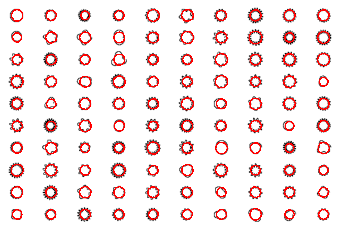

In [11]:
model = model.eval()
DonutDataset.displayCanvas('test3layerConstantWidth.png',test_dataset, model = model)


In [12]:
import torch
import torch.nn as nn
from torch.hub import load_state_dict_from_url

class MLP(nn.Module):
    def __init__(self):
        super(MLP, self).__init__()
        self.input_dim = 1*32*32
        self.output_dim = 2000
        self.net = nn.Sequential(
            nn.Linear(self.input_dim, self.input_dim),
            nn.ReLU(True),
            nn.Dropout(),
            nn.Linear(self.input_dim, self.input_dim),
            nn.ReLU(True),
            nn.Dropout(),
            nn.Linear(self.input_dim, self.input_dim),
            nn.ReLU(True),
            nn.Dropout(),
            nn.Linear(self.input_dim, self.input_dim),
            nn.ReLU(True),
            nn.Dropout(),
            nn.Linear(self.input_dim, self.output_dim),
            nn.Sigmoid()
        )
        
        

    def forward(self, x):
        #x = x.squeeze()
        if x.shape[0]!= mini_batch:
          assert x.shape[0] == 32 and x.shape[1] == 32
          x = x.unsqueeze(0)
        x = torch.flatten(x,start_dim=1)
        
        #assert x.shape == (mini_batch,self.hidden_dim)
        out = self.net(x)
        out = out.reshape(x.shape[0],1000,2)
        return 32.0*out


In [13]:
model = MLP().cuda()
optimizer = torch.optim.Adam(model.parameters(),lr = 0.0001, betas = (.9,.999))


In [14]:
loss = None
model = model.train()
for e in range(epoch):
  for xin,yin in loader_train:
    optimizer.zero_grad()

    if xin.shape[0] != mini_batch:
      print(xin.shape)
      continue
    xin = xin.cuda()
    yin = yin.cuda()
    out = model(xin)
    assert out.shape == yin.shape
    
    loss = torch.mean((out-yin)**2)
    loss.backward()
    optimizer.step()
    
  print('epoch',e,'\tTraining loss', loss.item())


/usr/local/lib/python3.7/dist-packages/torch/utils/data/dataloader.py:477: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  cpuset_checked))


epoch 0 	Training loss 14.927238464355469
epoch 1 	Training loss 5.47760009765625
epoch 2 	Training loss 3.6701467037200928
epoch 3 	Training loss 2.946200370788574
epoch 4 	Training loss 2.460895538330078
epoch 5 	Training loss 2.2689714431762695
epoch 6 	Training loss 2.156655788421631
epoch 7 	Training loss 2.052567481994629
epoch 8 	Training loss 1.8888776302337646
epoch 9 	Training loss 1.9255608320236206
epoch 10 	Training loss 1.8236209154129028
epoch 11 	Training loss 1.716876745223999
epoch 12 	Training loss 1.792588472366333
epoch 13 	Training loss 1.669321894645691
epoch 14 	Training loss 1.7616727352142334
epoch 15 	Training loss 1.6640918254852295
epoch 16 	Training loss 1.6098881959915161
epoch 17 	Training loss 1.6262887716293335
epoch 18 	Training loss 1.5736680030822754
epoch 19 	Training loss 1.5132687091827393
epoch 20 	Training loss 1.601184368133545
epoch 21 	Training loss 1.4770286083221436
epoch 22 	Training loss 1.4988150596618652
epoch 23 	Training loss 1.41773

In [15]:
optimizer = torch.optim.Adam(model.parameters(),lr = 0.00001, betas = (.9,.999))

In [16]:
loss = None
model = model.train()
for e in range(epoch):
  for xin,yin in loader_train:
    optimizer.zero_grad()
    if xin.shape[0] != mini_batch:
      print(xin.shape)
      continue
    xin = xin.cuda()
    yin = yin.cuda()
    out = model(xin)
    assert out.shape == yin.shape
    
    loss = torch.mean((out-yin)**2)
    loss.backward()
    optimizer.step()
    
  print('epoch',e,'\tTraining loss', loss.item())


/usr/local/lib/python3.7/dist-packages/torch/utils/data/dataloader.py:477: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  cpuset_checked))


epoch 0 	Training loss 1.3509429693222046
epoch 1 	Training loss 1.4404631853103638
epoch 2 	Training loss 1.4119741916656494
epoch 3 	Training loss 1.2388871908187866
epoch 4 	Training loss 1.3215652704238892
epoch 5 	Training loss 1.2186497449874878
epoch 6 	Training loss 1.2888635396957397
epoch 7 	Training loss 1.2152924537658691
epoch 8 	Training loss 1.421673059463501
epoch 9 	Training loss 1.2776566743850708
epoch 10 	Training loss 1.1950803995132446
epoch 11 	Training loss 1.4089293479919434
epoch 12 	Training loss 1.178876280784607
epoch 13 	Training loss 1.3251157999038696
epoch 14 	Training loss 1.39482581615448
epoch 15 	Training loss 1.3169991970062256
epoch 16 	Training loss 1.23634672164917
epoch 17 	Training loss 1.1693333387374878
epoch 18 	Training loss 1.344119906425476
epoch 19 	Training loss 1.2785422801971436
epoch 20 	Training loss 1.3931998014450073
epoch 21 	Training loss 1.1973084211349487
epoch 22 	Training loss 1.1876511573791504
epoch 23 	Training loss 1.37

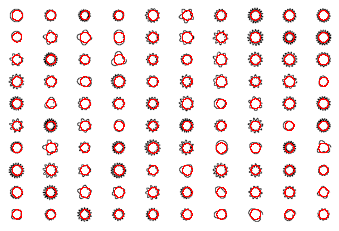

In [17]:
model = model.eval()
DonutDataset.displayCanvas('test6layerConstantWidth.png',test_dataset, model = model)


In [18]:
loss = None
model = model.eval()
total = 0.0
count = 0.0
for xin,yin in loader_test:
  if xin.shape[0] != mini_batch:
    print(xin.shape)
    continue
  xin = xin.cuda()
  yin = yin.cuda()
  out = model(xin)
  assert out.shape == yin.shape
  
  loss = torch.mean((out-yin)**2)
  count+=1.0
  total+=loss.item()
print('validation loss','\t', (float)(total/count))


/usr/local/lib/python3.7/dist-packages/torch/utils/data/dataloader.py:477: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  cpuset_checked))


torch.Size([36, 32, 32])
validation loss 	 1.883791208267212


In [19]:
import torch
import torch.nn as nn
from torch.hub import load_state_dict_from_url

class MLP(nn.Module):
    def __init__(self):
        super(MLP, self).__init__()
        self.input_dim = 1*32*32
        self.output_dim = 2000
        self.net = nn.Sequential(
            nn.Linear(self.input_dim, 10*self.input_dim),
            nn.ReLU(True),
            nn.Dropout(),
            nn.Linear(10*self.input_dim, 10*self.input_dim),
            nn.ReLU(True),
            nn.Dropout(),
            nn.Linear(10*self.input_dim, 10*self.input_dim),
            nn.ReLU(True),
            nn.Dropout(),
            nn.Linear(10*self.input_dim, 10*self.input_dim),
            nn.ReLU(True),
            nn.Dropout(),
            nn.Linear(10*self.input_dim, self.output_dim),
            nn.Sigmoid()
        )
        
        

    def forward(self, x):
        #x = x.squeeze()
        if x.shape[0]!= mini_batch:
          assert x.shape[0] == 32 and x.shape[1] == 32
          x = x.unsqueeze(0)
        x = torch.flatten(x,start_dim=1)
        
        #assert x.shape == (mini_batch,self.hidden_dim)
        out = self.net(x)
        out = out.reshape(x.shape[0],1000,2)
        return 32.0*out


In [20]:
model = MLP().cuda()
optimizer = torch.optim.Adam(model.parameters(),lr = 0.0001, betas = (.9,.999))


In [21]:
loss = None
model = model.train()
for e in range(epoch):
  for xin,yin in loader_train:
    optimizer.zero_grad()
    if xin.shape[0] != mini_batch:
      print(xin.shape)
      continue
    xin = xin.cuda()
    yin = yin.cuda()
    out = model(xin)
    assert out.shape == yin.shape
    
    loss = torch.mean((out-yin)**2)
    loss.backward()
    optimizer.step()
    
  print('epoch',e,'\tTraining loss', loss.item())


/usr/local/lib/python3.7/dist-packages/torch/utils/data/dataloader.py:477: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  cpuset_checked))


epoch 0 	Training loss 2.1823554039001465
epoch 1 	Training loss 1.8493082523345947
epoch 2 	Training loss 1.440995454788208
epoch 3 	Training loss 1.4443899393081665
epoch 4 	Training loss 1.3969368934631348
epoch 5 	Training loss 1.2881444692611694
epoch 6 	Training loss 1.3057034015655518
epoch 7 	Training loss 1.6732829809188843
epoch 8 	Training loss 1.2641626596450806
epoch 9 	Training loss 1.4546973705291748
epoch 10 	Training loss 1.451242208480835
epoch 11 	Training loss 1.6132327318191528
epoch 12 	Training loss 1.283246636390686
epoch 13 	Training loss 1.3009997606277466
epoch 14 	Training loss 1.2333753108978271
epoch 15 	Training loss 1.285152554512024
epoch 16 	Training loss 1.528831124305725
epoch 17 	Training loss 1.1534305810928345
epoch 18 	Training loss 1.329099178314209
epoch 19 	Training loss 1.3401174545288086
epoch 20 	Training loss 1.123481035232544
epoch 21 	Training loss 1.3298766613006592
epoch 22 	Training loss 1.2413476705551147
epoch 23 	Training loss 1.30

In [22]:
optimizer = torch.optim.Adam(model.parameters(),lr = 0.00001, betas = (.9,.999))


In [23]:
loss = None
model = model.train()
for e in range(epoch):
  for xin,yin in loader_train:
    optimizer.zero_grad()
    if xin.shape[0] != mini_batch:
      print(xin.shape)
      continue
    xin = xin.cuda()
    yin = yin.cuda()
    out = model(xin)
    assert out.shape == yin.shape
    
    loss = torch.mean((out-yin)**2)
    loss.backward()
    optimizer.step()
    
  print('epoch',e,'\tTraining loss', loss.item())


/usr/local/lib/python3.7/dist-packages/torch/utils/data/dataloader.py:477: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  cpuset_checked))


epoch 0 	Training loss 1.2581125497817993
epoch 1 	Training loss 1.2733030319213867
epoch 2 	Training loss 1.2430520057678223
epoch 3 	Training loss 1.0510190725326538
epoch 4 	Training loss 1.085792064666748
epoch 5 	Training loss 1.1876583099365234
epoch 6 	Training loss 1.1495791673660278
epoch 7 	Training loss 1.1736048460006714
epoch 8 	Training loss 1.1349557638168335
epoch 9 	Training loss 1.2379636764526367
epoch 10 	Training loss 1.1041117906570435
epoch 11 	Training loss 1.2111387252807617
epoch 12 	Training loss 1.075893759727478
epoch 13 	Training loss 1.2537422180175781
epoch 14 	Training loss 1.1597177982330322
epoch 15 	Training loss 1.265540361404419
epoch 16 	Training loss 1.0928179025650024
epoch 17 	Training loss 1.07379949092865
epoch 18 	Training loss 1.1930485963821411
epoch 19 	Training loss 1.258466124534607
epoch 20 	Training loss 1.1730570793151855
epoch 21 	Training loss 1.0909053087234497
epoch 22 	Training loss 1.1033066511154175
epoch 23 	Training loss 1.1

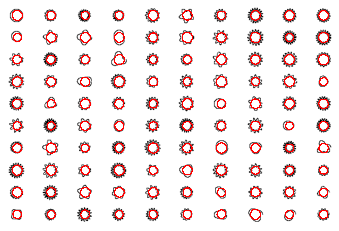

In [24]:
model = model.eval()
DonutDataset.displayCanvas('test6layer10xConstantWidth.png',test_dataset, model = model)


In [25]:
loss = None
model = model.eval()
total = 0.0
count = 0.0
for xin,yin in loader_test:
  if xin.shape[0] != mini_batch:
    print(xin.shape)
    continue
  xin = xin.cuda()
  yin = yin.cuda()
  out = model(xin)
  assert out.shape == yin.shape
  
  loss = torch.mean((out-yin)**2)
  count+=1.0
  total+=loss.item()
print('validation loss','\t', (float)(total/count))


/usr/local/lib/python3.7/dist-packages/torch/utils/data/dataloader.py:477: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  cpuset_checked))


torch.Size([36, 32, 32])
validation loss 	 2.1127171516418457


The 6 layer gets slow with 10x units. accuracy also gets worse.  


In [26]:
import torch
import torch.nn as nn
from torch.hub import load_state_dict_from_url

class MLP(nn.Module):
    def __init__(self):
        super(MLP, self).__init__()
        self.input_dim = 1*32*32
        self.output_dim = 2000
        self.net = nn.Sequential(
            nn.Linear(self.input_dim, 10*self.input_dim),
            nn.ReLU(True),
            nn.Dropout(),
            nn.Linear(10*self.input_dim, 10*self.input_dim),
            nn.ReLU(True),
            nn.Dropout(),
            nn.Linear(10*self.input_dim, self.output_dim),
            nn.Sigmoid()
        )
        
        

    def forward(self, x):
        #x = x.squeeze()
        if x.shape[0]!= mini_batch:
          assert x.shape[0] == 32 and x.shape[1] == 32
          x = x.unsqueeze(0)
        x = torch.flatten(x,start_dim=1)
        
        #assert x.shape == (mini_batch,self.hidden_dim)
        out = self.net(x)
        out = out.reshape(x.shape[0],1000,2)
        return 32.0*out


In [27]:
model = MLP().cuda()
optimizer = torch.optim.Adam(model.parameters(),lr = 0.0001, betas = (.9,.999))


In [28]:
loss = None
model = model.train()
for e in range(epoch):
  for xin,yin in loader_train:
    optimizer.zero_grad()
    if xin.shape[0] != mini_batch:
      print(xin.shape)
      continue
    xin = xin.cuda()
    yin = yin.cuda()
    out = model(xin)
    assert out.shape == yin.shape
    
    loss = torch.mean((out-yin)**2)
    loss.backward()
    optimizer.step()
    
  print('epoch',e,'\tTraining loss', loss.item())


/usr/local/lib/python3.7/dist-packages/torch/utils/data/dataloader.py:477: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  cpuset_checked))


epoch 0 	Training loss 2.5344064235687256
epoch 1 	Training loss 1.7464566230773926
epoch 2 	Training loss 1.6583313941955566
epoch 3 	Training loss 1.4032869338989258
epoch 4 	Training loss 1.4135515689849854
epoch 5 	Training loss 1.3473091125488281
epoch 6 	Training loss 1.2870804071426392
epoch 7 	Training loss 1.1912442445755005
epoch 8 	Training loss 1.158599615097046
epoch 9 	Training loss 1.071050763130188
epoch 10 	Training loss 1.0548179149627686
epoch 11 	Training loss 0.9149413108825684
epoch 12 	Training loss 0.9714774489402771
epoch 13 	Training loss 0.6973667144775391
epoch 14 	Training loss 0.6784777045249939
epoch 15 	Training loss 0.6004498600959778
epoch 16 	Training loss 0.5705833435058594
epoch 17 	Training loss 0.582973062992096
epoch 18 	Training loss 0.5656788349151611
epoch 19 	Training loss 0.5782579779624939
epoch 20 	Training loss 0.49636027216911316
epoch 21 	Training loss 0.5049497485160828
epoch 22 	Training loss 0.467873215675354
epoch 23 	Training loss 

In [29]:
optimizer = torch.optim.Adam(model.parameters(),lr = 0.00001, betas = (.9,.999))


In [30]:
loss = None
model = model.train()
for e in range(epoch):
  for xin,yin in loader_train:
    optimizer.zero_grad()
    if xin.shape[0] != mini_batch:
      print(xin.shape)
      continue
    xin = xin.cuda()
    yin = yin.cuda()
    out = model(xin)
    assert out.shape == yin.shape
    
    loss = torch.mean((out-yin)**2)
    loss.backward()
    optimizer.step()
    
  print('epoch',e,'\tTraining loss', loss.item())


/usr/local/lib/python3.7/dist-packages/torch/utils/data/dataloader.py:477: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  cpuset_checked))


epoch 0 	Training loss 0.3123745322227478
epoch 1 	Training loss 0.28763943910598755
epoch 2 	Training loss 0.2833578288555145
epoch 3 	Training loss 0.282309889793396
epoch 4 	Training loss 0.2852751612663269
epoch 5 	Training loss 0.2799469530582428
epoch 6 	Training loss 0.2600049376487732
epoch 7 	Training loss 0.2858962416648865
epoch 8 	Training loss 0.2648222744464874
epoch 9 	Training loss 0.2711678147315979
epoch 10 	Training loss 0.2650390863418579
epoch 11 	Training loss 0.27811938524246216
epoch 12 	Training loss 0.26434847712516785
epoch 13 	Training loss 0.26023387908935547
epoch 14 	Training loss 0.24770526587963104
epoch 15 	Training loss 0.23495368659496307
epoch 16 	Training loss 0.2607541084289551
epoch 17 	Training loss 0.24026760458946228
epoch 18 	Training loss 0.2449270337820053
epoch 19 	Training loss 0.23686347901821136
epoch 20 	Training loss 0.22735384106636047
epoch 21 	Training loss 0.2184714823961258
epoch 22 	Training loss 0.23533160984516144
epoch 23 	Tr

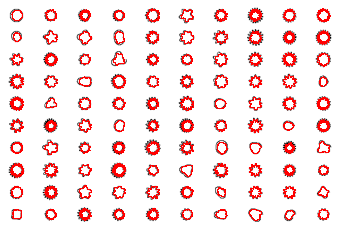

In [31]:
model = model.eval()
DonutDataset.displayCanvas('test3layer10xConstantWidth.png',test_dataset, model = model)


In [32]:
loss = None
model = model.eval()
total = 0.0
count = 0.0
for xin,yin in loader_test:
  if xin.shape[0] != mini_batch:
    print(xin.shape)
    continue
  xin = xin.cuda()
  yin = yin.cuda()
  out = model(xin)
  assert out.shape == yin.shape
  
  loss = torch.mean((out-yin)**2)
  count+=1.0
  total+=loss.item()
print('validation loss','\t', (float)(total/count))


/usr/local/lib/python3.7/dist-packages/torch/utils/data/dataloader.py:477: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  cpuset_checked))


torch.Size([36, 32, 32])
validation loss 	 0.4470389187335968


In [33]:
import torch
import torch.nn as nn
from torch.hub import load_state_dict_from_url

class MLP(nn.Module):
    def __init__(self):
        super(MLP, self).__init__()
        self.input_dim = 1*32*32
        self.output_dim = 2000
        self.net = nn.Sequential(
            nn.Linear(self.input_dim, 100*self.input_dim),
            nn.ReLU(),
            nn.Dropout(),
            nn.Linear(100*self.input_dim, self.output_dim),
            nn.Sigmoid()
        )
        
        

    def forward(self, x):

      #x = x.squeeze()
      if x.shape[0]!= mini_batch:
        assert x.shape[0] == 32 and x.shape[1] == 32
        x = x.unsqueeze(0)
      x = torch.flatten(x,start_dim=1)
      
      #assert x.shape == (mini_batch,self.hidden_dim)
      out = self.net(x)
      out = out.reshape(x.shape[0],1000,2)
      return 32.0*out


In [34]:
model = MLP().cuda()
optimizer = torch.optim.Adam(model.parameters(),lr = 0.0001, betas = (.9,.999))


In [35]:
loss = None
#model = model.train()
for e in range(epoch):
  for xin,yin in loader_train:
    optimizer.zero_grad()
    if xin.shape[0] != mini_batch:
      print(xin.shape)
      continue
    xin = xin.cuda()
    yin = yin.cuda()
    out = model(xin)
    assert out.shape == yin.shape
    
    loss = torch.mean((out-yin)**2)
    loss.backward()
    optimizer.step()
  

  print('epoch',e,'\tTraining loss', loss.item())


/usr/local/lib/python3.7/dist-packages/torch/utils/data/dataloader.py:477: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  cpuset_checked))


epoch 0 	Training loss 2.3172197341918945
epoch 1 	Training loss 1.1609402894973755
epoch 2 	Training loss 0.9308860898017883
epoch 3 	Training loss 0.6234790086746216
epoch 4 	Training loss 0.5441758036613464
epoch 5 	Training loss 0.41322529315948486
epoch 6 	Training loss 0.3052016794681549
epoch 7 	Training loss 0.2697821259498596
epoch 8 	Training loss 0.2294970452785492
epoch 9 	Training loss 0.20167627930641174
epoch 10 	Training loss 0.1797637790441513
epoch 11 	Training loss 0.17636564373970032
epoch 12 	Training loss 0.1646060347557068
epoch 13 	Training loss 0.1465693712234497
epoch 14 	Training loss 0.1371590942144394
epoch 15 	Training loss 0.13729719817638397
epoch 16 	Training loss 0.12485995888710022
epoch 17 	Training loss 0.12212539464235306
epoch 18 	Training loss 0.11866344511508942
epoch 19 	Training loss 0.1118619292974472
epoch 20 	Training loss 0.11017545312643051
epoch 21 	Training loss 0.11205371469259262
epoch 22 	Training loss 0.10592790693044662
epoch 23 	T

In [36]:
optimizer = torch.optim.Adam(model.parameters(),lr = 0.00001, betas = (.9,.999))


In [37]:
loss = None
#model = model.train()
for e in range(epoch):
  for xin,yin in loader_train:
    optimizer.zero_grad()
    if xin.shape[0] != mini_batch:
      print(xin.shape)
      continue
    xin = xin.cuda()
    yin = yin.cuda()
    out = model(xin)
    assert out.shape == yin.shape
    
    loss = torch.mean((out-yin)**2)
    loss.backward()
    optimizer.step()
    
  print('epoch',e,'\tTraining loss', loss.item())


/usr/local/lib/python3.7/dist-packages/torch/utils/data/dataloader.py:477: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  cpuset_checked))


epoch 0 	Training loss 0.06930600106716156
epoch 1 	Training loss 0.06784682720899582
epoch 2 	Training loss 0.06349044293165207
epoch 3 	Training loss 0.06493262201547623
epoch 4 	Training loss 0.06240205094218254
epoch 5 	Training loss 0.06196127459406853
epoch 6 	Training loss 0.06072419136762619
epoch 7 	Training loss 0.05913081765174866
epoch 8 	Training loss 0.05906645581126213
epoch 9 	Training loss 0.05634034797549248
epoch 10 	Training loss 0.05953329801559448
epoch 11 	Training loss 0.05729756876826286
epoch 12 	Training loss 0.06007470190525055
epoch 13 	Training loss 0.05690377950668335
epoch 14 	Training loss 0.054190754890441895
epoch 15 	Training loss 0.05501546338200569
epoch 16 	Training loss 0.053142424672842026
epoch 17 	Training loss 0.05666597560048103
epoch 18 	Training loss 0.052786532789468765
epoch 19 	Training loss 0.05207475274801254
epoch 20 	Training loss 0.05265412852168083
epoch 21 	Training loss 0.051058635115623474
epoch 22 	Training loss 0.051480647176

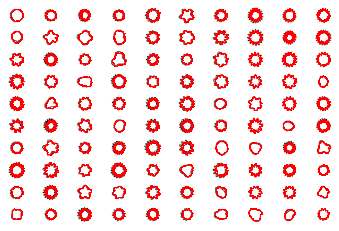

In [38]:
DonutDataset.displayCanvas('test2layer100x.png',test_dataset, model = model)


In [39]:
loss = None
model = model.eval()
total = 0.0
count = 0.0
for xin,yin in loader_test:
  if xin.shape[0] != mini_batch:
    print(xin.shape)
    continue
  xin = xin.cuda()
  yin = yin.cuda()
  out = model(xin)
  assert out.shape == yin.shape
  
  loss = torch.mean((out-yin)**2)
  count+=1.0
  total+=loss.item()
print('validation loss','\t', (float)(total/count))


/usr/local/lib/python3.7/dist-packages/torch/utils/data/dataloader.py:477: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  cpuset_checked))


torch.Size([36, 32, 32])
validation loss 	 0.2346706986427307


In [40]:
import torch
import torch.nn as nn
from torch.hub import load_state_dict_from_url

class MLP(nn.Module):
    def __init__(self):
        super(MLP, self).__init__()
        self.input_dim = 1*32*32
        self.output_dim = 2000
        self.net = nn.Sequential(
            nn.Linear(self.input_dim, self.output_dim),
            nn.Sigmoid()
        )
        
        

    def forward(self, x):
        #x = x.squeeze()
        if x.shape[0]!= mini_batch:
          assert x.shape[0] == 32 and x.shape[1] == 32
          x = x.unsqueeze(0)
        x = torch.flatten(x,start_dim=1)
        
        #assert x.shape == (mini_batch,self.hidden_dim)
        out = self.net(x)
        out = out.reshape(x.shape[0],1000,2)
        return 32.0*out


In [41]:
model = MLP().cuda()
optimizer = torch.optim.Adam(model.parameters(),lr = 0.0001, betas = (.9,.999))


In [42]:
loss = None
model = model.train()
for e in range(epoch):
  for xin,yin in loader_train:
    optimizer.zero_grad()
    if xin.shape[0] != mini_batch:
      print(xin.shape)
      continue
    xin = xin.cuda()
    yin = yin.cuda()
    out = model(xin)
    assert out.shape == yin.shape
    
    loss = torch.mean((out-yin)**2)
    loss.backward()
    optimizer.step()
    
  print('epoch',e,'\tTraining loss', loss.item())


/usr/local/lib/python3.7/dist-packages/torch/utils/data/dataloader.py:477: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  cpuset_checked))


epoch 0 	Training loss 28.699047088623047
epoch 1 	Training loss 16.587995529174805
epoch 2 	Training loss 11.262181282043457
epoch 3 	Training loss 8.044723510742188
epoch 4 	Training loss 7.0740742683410645
epoch 5 	Training loss 5.490173816680908
epoch 6 	Training loss 5.036618232727051
epoch 7 	Training loss 5.127458095550537
epoch 8 	Training loss 5.649625301361084
epoch 9 	Training loss 4.79372501373291
epoch 10 	Training loss 4.397269248962402
epoch 11 	Training loss 4.598071575164795
epoch 12 	Training loss 4.812934398651123
epoch 13 	Training loss 4.775607585906982
epoch 14 	Training loss 3.5956764221191406
epoch 15 	Training loss 4.696722030639648
epoch 16 	Training loss 4.057436943054199
epoch 17 	Training loss 3.8033854961395264
epoch 18 	Training loss 4.076400279998779
epoch 19 	Training loss 3.679959535598755
epoch 20 	Training loss 4.043046951293945
epoch 21 	Training loss 4.100944519042969
epoch 22 	Training loss 3.882178783416748
epoch 23 	Training loss 3.6867880821228

In [43]:
optimizer = torch.optim.Adam(model.parameters(),lr = 0.00001, betas = (.9,.999))


In [44]:
loss = None
model = model.train()
for e in range(epoch):
  for xin,yin in loader_train:
    optimizer.zero_grad()
    if xin.shape[0] != mini_batch:
      print(xin.shape)
      continue
    xin = xin.cuda()
    yin = yin.cuda()
    out = model(xin)
    assert out.shape == yin.shape
    
    loss = torch.mean((out-yin)**2)
    loss.backward()
    optimizer.step()
    
  print('epoch',e,'\tTraining loss', loss.item())


/usr/local/lib/python3.7/dist-packages/torch/utils/data/dataloader.py:477: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  cpuset_checked))


epoch 0 	Training loss 3.4815948009490967
epoch 1 	Training loss 3.268822431564331
epoch 2 	Training loss 3.0888936519622803
epoch 3 	Training loss 3.151909351348877
epoch 4 	Training loss 3.142803192138672
epoch 5 	Training loss 3.022376537322998
epoch 6 	Training loss 3.33420729637146
epoch 7 	Training loss 3.1246697902679443
epoch 8 	Training loss 3.0956013202667236
epoch 9 	Training loss 3.0247247219085693
epoch 10 	Training loss 3.607912302017212
epoch 11 	Training loss 3.239666223526001
epoch 12 	Training loss 3.324228048324585
epoch 13 	Training loss 3.319628953933716
epoch 14 	Training loss 3.2604269981384277
epoch 15 	Training loss 3.0012381076812744
epoch 16 	Training loss 2.9552013874053955
epoch 17 	Training loss 3.0993239879608154
epoch 18 	Training loss 3.2845420837402344
epoch 19 	Training loss 2.9256231784820557
epoch 20 	Training loss 3.376995086669922
epoch 21 	Training loss 3.1355741024017334
epoch 22 	Training loss 2.835202217102051
epoch 23 	Training loss 3.5735547

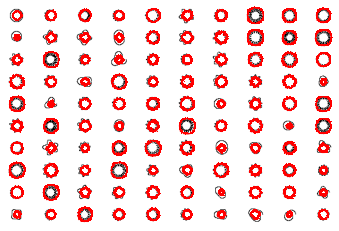

In [45]:
model = model.eval()
DonutDataset.displayCanvas('test1layer.png',test_dataset, model = model)


In [46]:
loss = None
model = model.eval()
total = 0.0
count = 0.0
for xin,yin in loader_test:
  if xin.shape[0] != mini_batch:
    print(xin.shape)
    continue
  xin = xin.cuda()
  yin = yin.cuda()
  out = model(xin)
  assert out.shape == yin.shape
  
  loss = torch.mean((out-yin)**2)
  count+=1.0
  total+=loss.item()
print('validation loss','\t', (float)(total/count))


/usr/local/lib/python3.7/dist-packages/torch/utils/data/dataloader.py:477: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  cpuset_checked))


torch.Size([36, 32, 32])
validation loss 	 4.490365505218506
